In [ ]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
from tensorflow.keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
#from tensorflow.keras.utils import np_utils
from skimage.transform import resize   # for resizing images
from glob import glob
from tqdm import tqdm

import keras
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing import image
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import load_img, img_to_array

from scipy import stats as s

# Load data prepared in the 'Prepara data' notebook

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train_split = pd.read_csv('/content/gdrive/MyDrive/Bundesliga Kaggle Challenge/train_split.csv')
train_split.shape

(3000, 2)

In [ ]:
train_split['class'].unique()

array(['play', 'throwin', 'challenge'], dtype=object)

In [ ]:
import pickle

with open('/content/gdrive/MyDrive/Bundesliga Kaggle Challenge/X.pkl','rb') as f:
    X = pickle.load(f)

In [ ]:
X.shape

(3000, 224, 224, 3)

# Create a validation set 

In [ ]:
# separating the target
y = train_split['class']

# creating the training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify = y)

In [ ]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [ ]:
y_test

,challenge,play,throwin
2082,1,0,0
163,0,1,0
1932,0,1,0
1922,1,0,0
1660,0,1,0
...,...,...,...
927,0,1,0
2448,0,1,0
1423,0,1,0
733,0,1,0


In [ ]:
y_train.shape

(2400, 3)

# Define the architecture the model and transform data

In [ ]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
base_model.trainable = False

In [ ]:
# creating the base model of pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# extracting features for training frames
X_train = base_model.predict(X_train)
X_train.shape

75/75 [==============================] - 20s 136ms/step


(2400, 7, 7, 512)

In [ ]:
# extracting features for validation frames
X_test = base_model.predict(X_test)
X_test.shape

19/19 [==============================] - 5s 256ms/step


(600, 7, 7, 512)

In [ ]:
# reshaping the training as well as validation frames in single dimension
X_train = X_train.reshape(2400, 7*7*512)
X_test = X_test.reshape(600, 7*7*512)

In [ ]:
# normalizing the pixel values
max = X_train.max()
X_train = X_train/max
X_test = X_test/max

In [ ]:
# shape of images
X_train.shape

(2400, 25088)

In [ ]:
model = Sequential()
model.add(layers.Conv2D(16, (3,3), input_shape=(25088,), padding='same', activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(32, (2,2), padding='same', activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2))) 
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu')) # intermediate layer
model.add(layers.Dense(3, activation='softmax'))

ValueError: ignored

In [ ]:
#defining the model architecture
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(25088,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# Train the model and save weights

In [ ]:
# defining a function to save the weights of best model
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('weight.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
# compiling the model
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1, restore_best_weights=True)

In [ ]:
# training the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[mcp_save, es], batch_size=16)

Epoch 1/20
150/150 [==============================] - 3s 17ms/step - loss: 0.7445 - accuracy: 0.7783 - val_loss: 0.5724 - val_accuracy: 0.8133
Epoch 2/20
150/150 [==============================] - 1s 9ms/step - loss: 0.6234 - accuracy: 0.8108 - val_loss: 0.6275 - val_accuracy: 0.8133
Epoch 3/20
150/150 [==============================] - 1s 9ms/step - loss: 0.6002 - accuracy: 0.8125 - val_loss: 0.5955 - val_accuracy: 0.8133
Epoch 4/20
150/150 [==============================] - 1s 9ms/step - loss: 0.5828 - accuracy: 0.8125 - val_loss: 0.6222 - val_accuracy: 0.8133
Epoch 5/20
150/150 [==============================] - 3s 18ms/step - loss: 0.5769 - accuracy: 0.8125 - val_loss: 0.5677 - val_accuracy: 0.8133
Epoch 6/20
150/150 [==============================] - 1s 9ms/step - loss: 0.5631 - accuracy: 0.8125 - val_loss: 0.5730 - val_accuracy: 0.8133
Epoch 6: early stopping


In [ ]:
# Plot Train & Validation accuracy per epoch
# Calculate accuracy X_test dataset

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print(f'The accuracy on the test set is of {results[1]:.2f}')

The accuracy on the test set is of 0.81


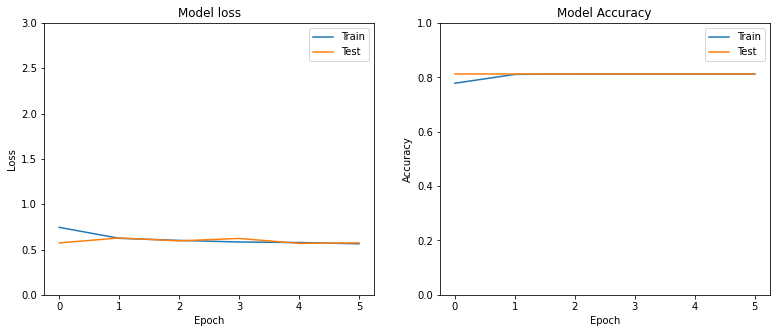

In [ ]:
# PLOT LOSS / METRICS

def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(13,5))
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,1))
    if title:
        fig.suptitle(title)

plot_loss_accuracy(history)

# Load the model and data to be predicted

In [ ]:
#defining the model architecture
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(25088,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

In [ ]:
model.load_weights("/content//weight.hdf5")

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [ ]:
import pickle

with open('/content/gdrive/MyDrive/Bundesliga Kaggle Challenge/X_predict.pkl','rb') as f:
    X_predict = pickle.load(f)

In [ ]:
X_predict.shape

(960, 224, 224, 3)

In [ ]:
# extracting features for validation frames
X_predict = base_model.predict(X_predict)
X_predict.shape

InvalidArgumentError: ignored

In [ ]:
X_predict = X_predict.reshape(960, 7*7*512)

In [ ]:
max = X_predict.max()
X_predict = X_predict/max

In [ ]:
prediction = model.predict(X_predict)

30/30 [==============================] - 0s 3ms/step


In [ ]:
pd.DataFrame(prediction)

,0,1,2
0,0.263969,0.656555,0.079476
1,0.252517,0.679835,0.067647
2,0.277620,0.625912,0.096468
3,0.229415,0.718106,0.052479
4,0.240945,0.698364,0.060691
...,...,...,...
955,0.283781,0.611749,0.104470
956,0.284586,0.610556,0.104857
957,0.289300,0.599048,0.111653
958,0.295493,0.583659,0.120848


In [ ]:
np.argmax(prediction, axis=1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
predict_data = pd.read_csv('/content/gdrive/MyDrive/Bundesliga Kaggle Challenge/predict_new.csv')
predict_data.head()

,image
0,019d5b34_0.mp4_frame0.jpg
1,019d5b34_0.mp4_frame1.jpg
2,019d5b34_0.mp4_frame10.jpg
3,019d5b34_0.mp4_frame11.jpg
4,019d5b34_0.mp4_frame12.jpg
